Name: Ritika Ugale  
Email: ritika.ugale@uni-potsdam.de

# Creditworthiness Prediction
------------------------------------------------------------------------------------------------------------------------------------------
## Problem Definition

* Objective:

A bank aims to develop a predictive model to assess the **creditworthiness of its customers**. Using customer records—including financial information, credit history, and demographic attributes—each customer should be classified as either **creditworthy or not creditworthy**.

* Learning Problem:

Supervised Learning: given input–output pairs (features + known label).   
Classification problem: target variable is categorical (creditworthy vs. not creditworthy).

* Input Attributes (Features)

1. Status of existing checking account
2. Duration in months
3. Credit history
4. Purpose
5. Credit amount
6. Savings account/bonds
7. Present employment since
8. Installment rate in % of disposable income
9. Personal status and sex
10. Other debtors/guarantors
11. Present residence since
12. Property
13. Age in years
14. Other installment plans
15. Housing
16. Number of existing credits at this bank
17. Job
18. Number of people liable to provide maintenance
19. Telephone
20. Foreign worker

* Target Variable (Label)

Let (y) be the target variable  
Creditworthiness ->  
(y=1) = Applicant is creditworthy         
(y=2) = Applicant is not creditworthy

* Business Impact

  Accurately predicting creditworthiness provides multiple benefits:
  
  Reduce financial risk: Decrease loan defaults by identifying risky applicants.  
  Improve efficiency: Automate credit decision-making.  
  Increase profitability: Grant safe loans faster and to more customers.  

  -----------------------------------------------------------------------------------------------------------------------------------------

In [1]:
#Import the libraries/packages needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.baseline_CV import baseline_kfold
from scripts.model_CV import kfold_cv
from scripts.models_nestedcv import nested_cv
from scripts.model_nested_SVM import nested_cv_svm

## Data Importing and Preprocessing

Load the dataset from kredit.dat and preview the first five rows to understand its structure and spot any formatting issues or missing values.
- loaded dataset
- assigned meaningfull column names

In [2]:
data = pd.read_csv("../data/kredit.dat", sep=r'\s+',header=None)

In [3]:
columns = [
    "checking_status", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment", "installment_rate", "personal_status_sex", "guarantors",
    "residence_since", "property", "age", "other_installment", "housing",
    "existing_credits", "job", "dependents", "telephone", "foreign_worker", "creditworthy"
]

data.columns = columns

# Inspect dataset
print(data.shape)
print(data.head())
print(data.info())


(1000, 21)
  checking_status  duration credit_history purpose  credit_amount savings  \
0             A14        36            A32       ?           2299     A63   
1             A12        18            A32     A46           1239     A65   
2             A13        24            A32     A40            947     A61   
3             A14        15            A33     A43           1478     A61   
4             A14        24            A32     A40           1525     A64   

  employment  installment_rate personal_status_sex guarantors  ...  property  \
0          ?                 4                 A93       A101  ...      A123   
1        A73                 4                 A93       A101  ...      A124   
2        A74                 4                 A93       A101  ...      A124   
3        A73                 4                 A94       A101  ...      A121   
4        A74                 4                 A92       A101  ...      A123   

  age  other_installment housing existing_cre

### Observation from the result:

* The dataset has 1,000 rows and 21 columns, which is a moderate size suitable for classic ML models and quick iteration.
* There are 8 numeric columns and 13 categorical columns, so preprocessing will need both scaling for numerics and encoding for categoricals.

Missing values are encoded as "?" in columns:  
* purpose  
* employment  
* job  
* foreign_worker   

### Handle missing values

In [4]:
#Replace the missing value by nan 
data = data.replace("?", np.nan)

# Count missing values per column
missing_counts = data.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
print(missing_counts)

# Give labels to 'Creditworthy' [1,2] -> [1,0]
data['creditworthy'] = data['creditworthy'].map({1: 1, 2: 0})  # 1 = Creditworthy, 0 = Not Creditworthy

purpose           173
employment        496
job               232
foreign_worker    360
dtype: int64


creditworthy
1    700
0    300
Name: count, dtype: int64


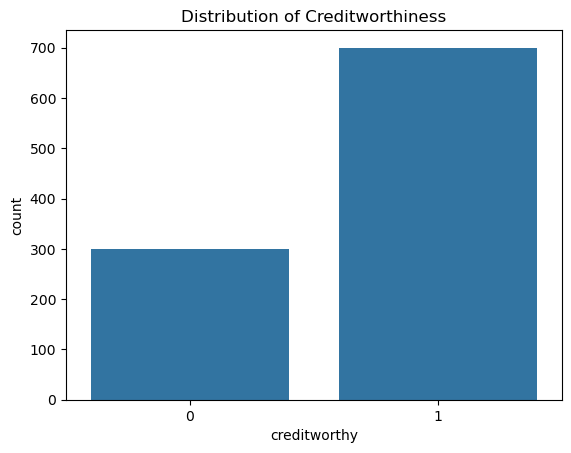

In [5]:
# Plot frequency of each class label
print(data['creditworthy'].value_counts())     # number of occurrences of each unique value in the Series
sns.countplot(x="creditworthy", data=data)     # shows the distribution visually
plt.title("Distribution of Creditworthiness")
plt.show()

In [6]:
# Identify numeric and categorical features
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'dependents', 'creditworthy']
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings', 'employment', 'personal_status_sex', 'guarantors', 'property', 'other_installment', 'housing', 'job', 'telephone', 'foreign_worker']


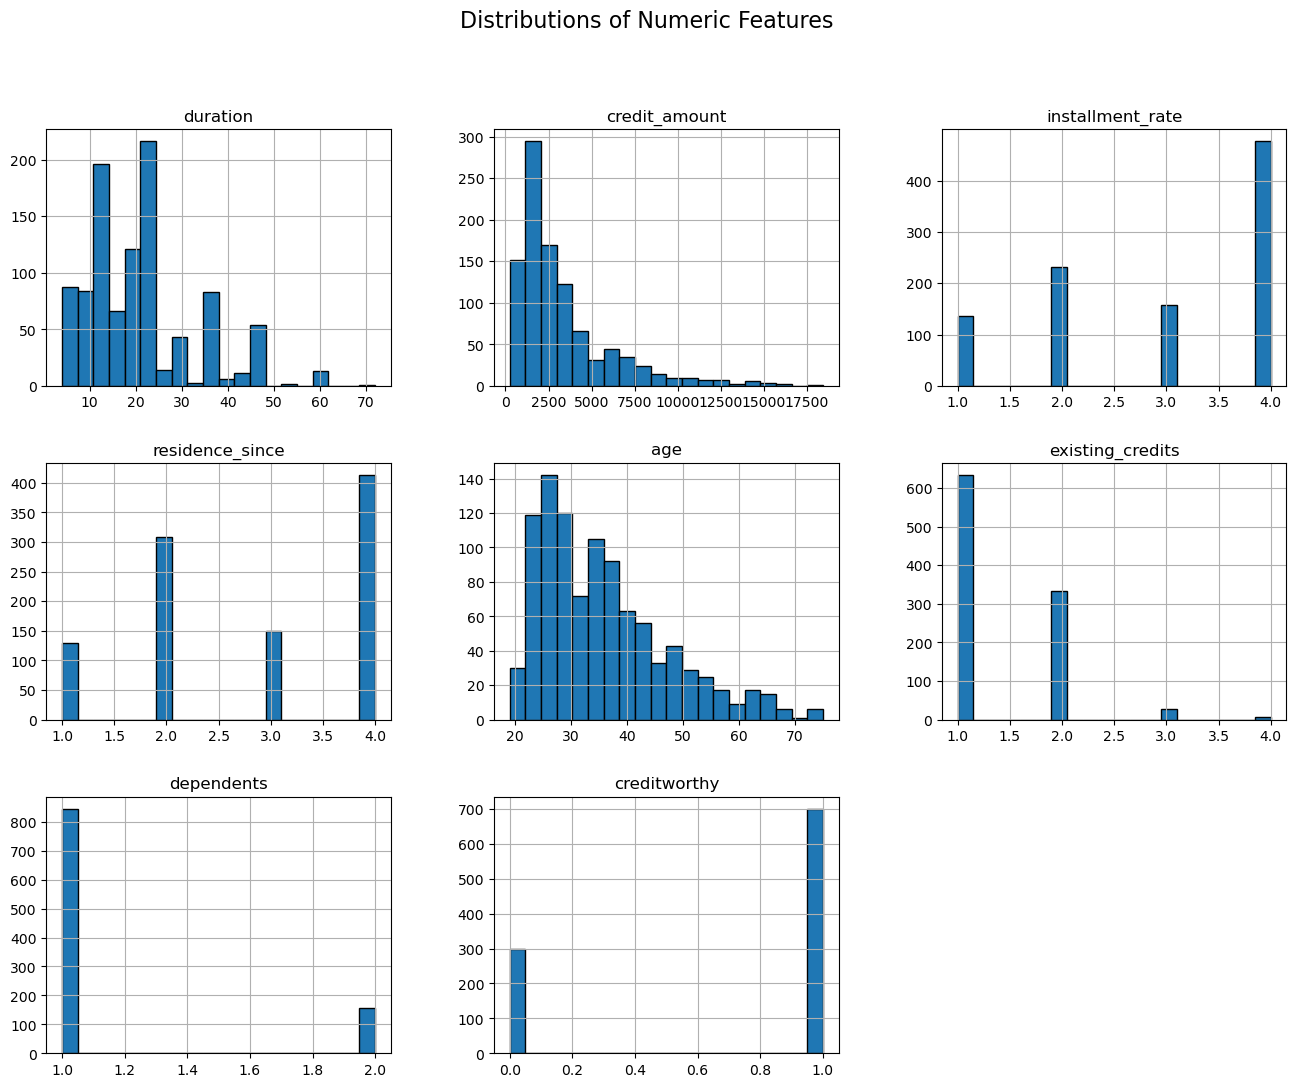

In [7]:
# visualize the distribution of all numeric features in dataset

data[numeric_cols].hist(figsize=(16, 12), bins=20, edgecolor="black")
plt.suptitle("Distributions of Numeric Features", fontsize=16)
plt.grid()
plt.show()

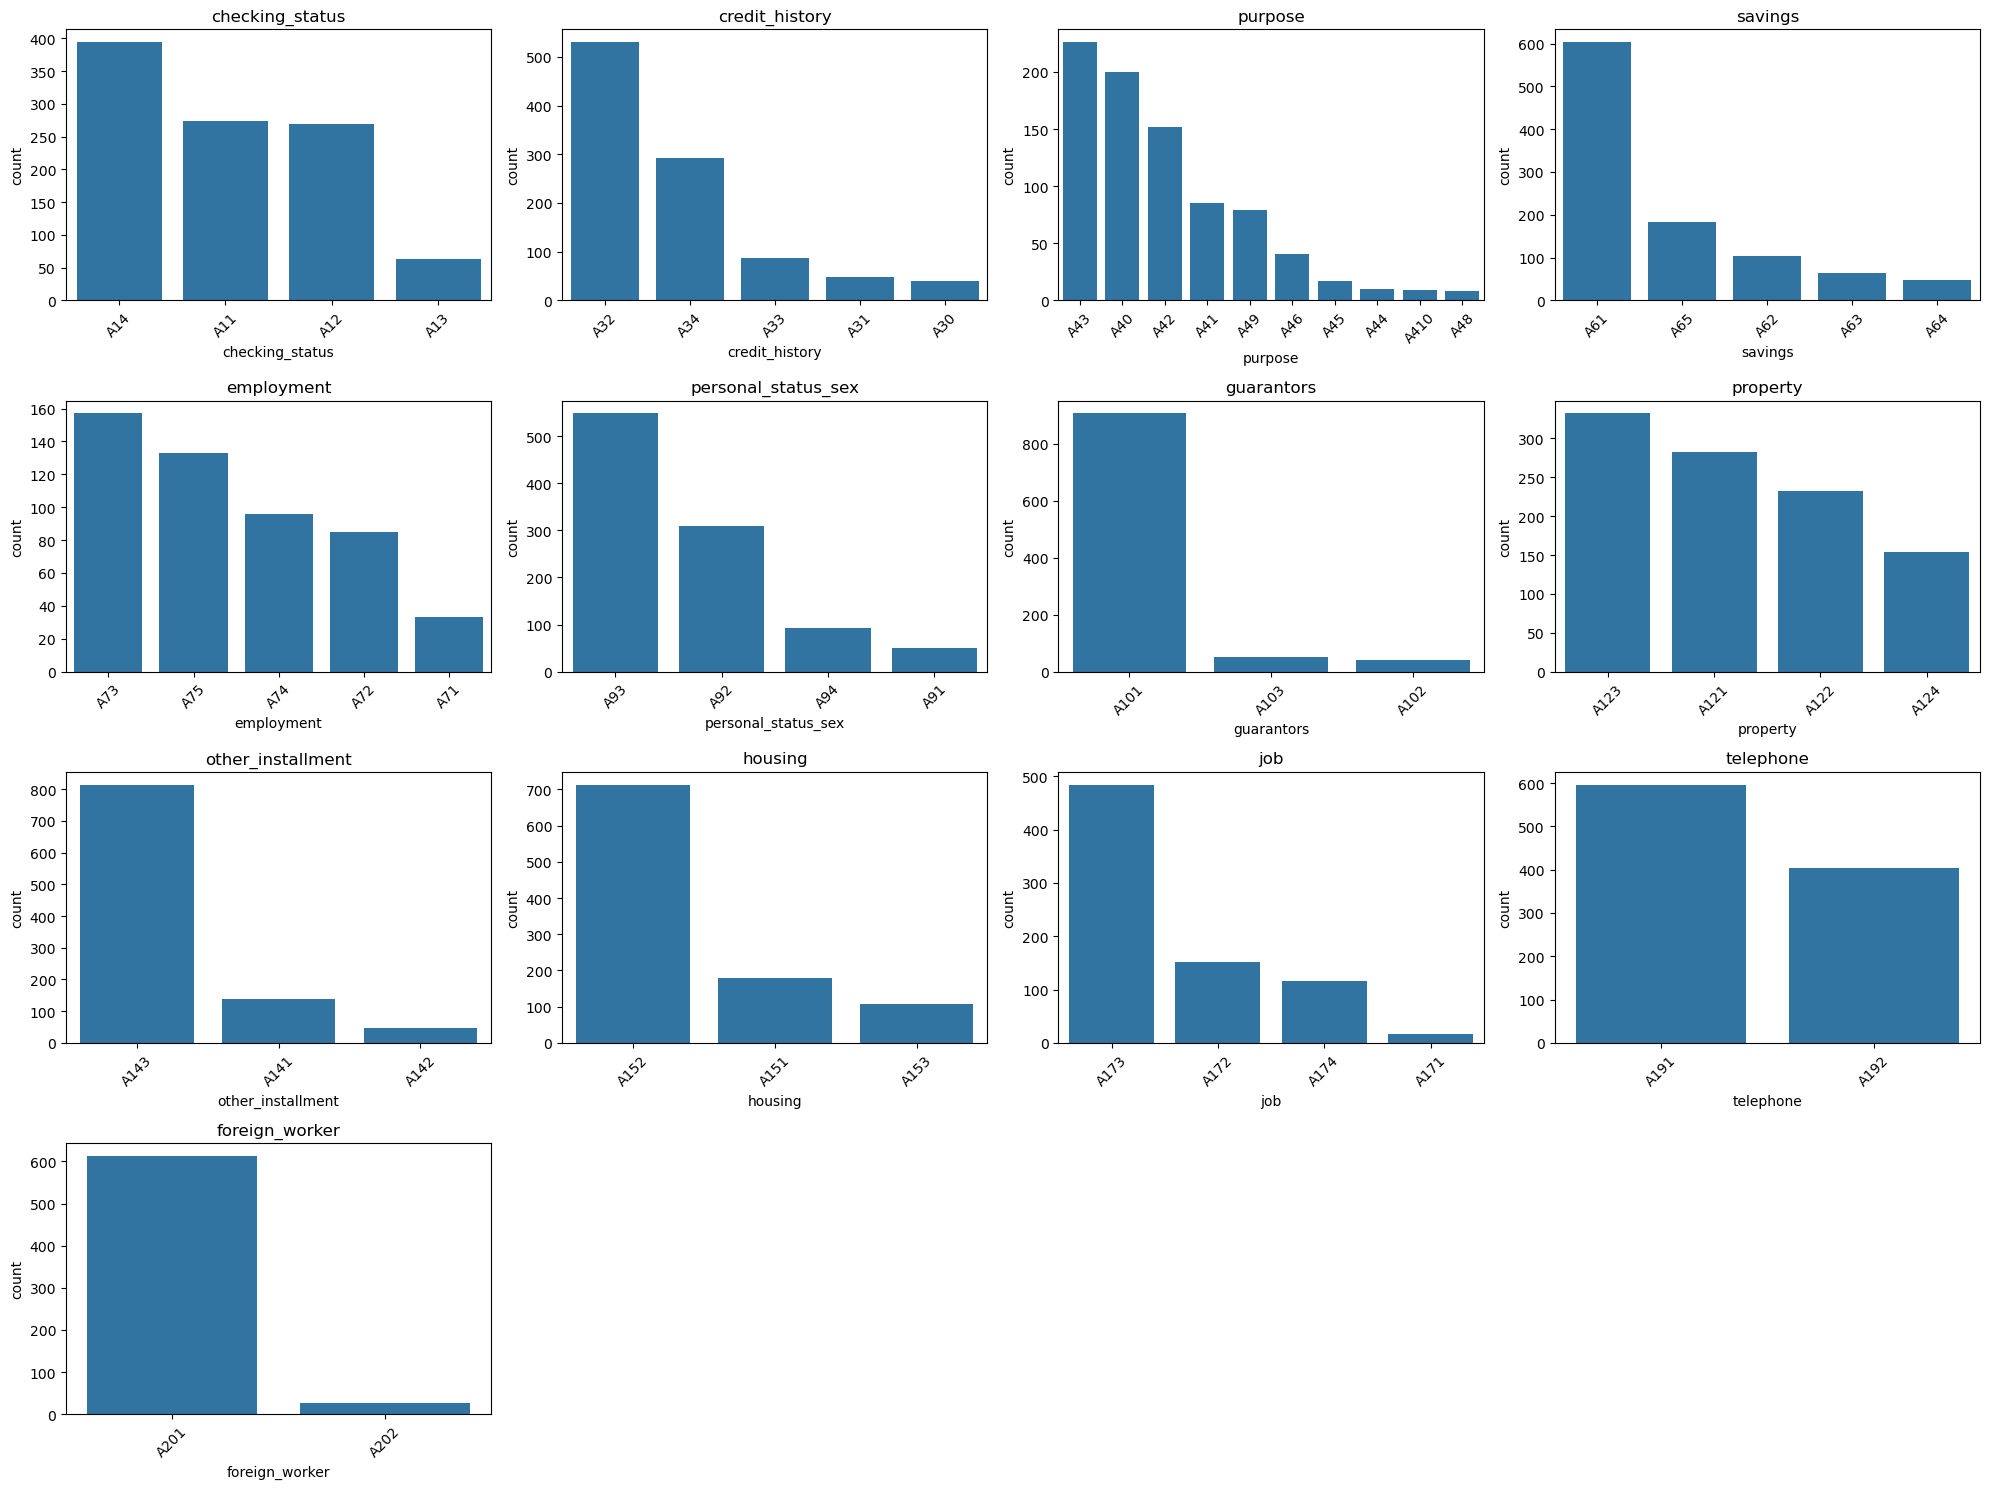

In [8]:
# Shows frequency distributions for each categorical feature via count plots.

fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # adjust grid size to fit your features
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(x=col, data=data, order=data[col].value_counts().index, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# Hide the unused axes
for ax in axes[len(categorical_cols):]:
    ax.set_visible(False)
    
plt.tight_layout()
plt.show()

## Missing Values 

For categorical columns with missing values, Decision Tree are trained on the rows where the values were known and then used it to predict the missing categories. This way, the imputation is based on patterns in the data instead of simply filling with the most frequent category.

We can replace the missing values with nan first to make the computations easy  
we dont use different approaches because:
1) drop the NA values: This can lead to risk of losing the data
2) Replacing with mean :  mean is sensitive to outliers/ extreme values
3) Replacing with median : Replacing the nan values with median is better method as median gives a better central tendency, but not based on patterns in data.

In [9]:
from sklearn.tree import DecisionTreeClassifier

for col in categorical_cols:
    if data[col].isna().sum() == 0:
        continue  # Skip columns with no missing values
        
    # Split data into rows with and without missing values
    train = data[data[col].notna()]
    test = data[data[col].isna()]
    
    # Create features by dropping all categorical columns
    X_train = pd.get_dummies(train.drop(columns=categorical_cols), drop_first=True)
    X_test = pd.get_dummies(test.drop(columns=categorical_cols), drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    # Train Decision Tree and predict
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, train[col])
    data.loc[test.index, col] = clf.predict(X_test)

# Check missing values
print(data[categorical_cols].isna().sum())

checking_status        0
credit_history         0
purpose                0
savings                0
employment             0
personal_status_sex    0
guarantors             0
property               0
other_installment      0
housing                0
job                    0
telephone              0
foreign_worker         0
dtype: int64


In [10]:
data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status_sex,guarantors,...,property,age,other_installment,housing,existing_credits,job,dependents,telephone,foreign_worker,creditworthy
0,A14,36,A32,A43,2299,A63,A75,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,A201,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,A172,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,A173,2,A191,A201,0
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


## Feature Map

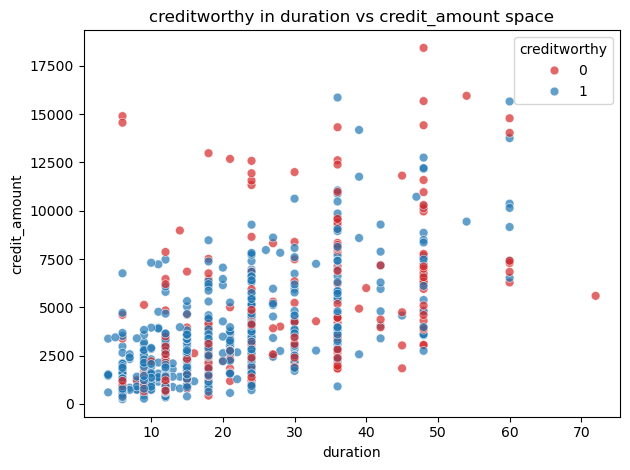

In [11]:
# two numeric features and the target
feat_x = "duration"          
feat_y = "credit_amount"     
target = "creditworthy"     

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=data, x=feat_x, y=feat_y,
                hue=target, palette={0:"tab:red", 1:"tab:blue"},
                alpha=0.7, s=40)
plt.title(f"{target} in {feat_x} vs {feat_y} space")
plt.tight_layout()
plt.show()


##  Normalization
Z score normalization is applied to each instance.

$$
z = \frac{x - \mu}{\sigma}
$$

In [12]:
numeric_cols = [col for col in numeric_cols if col != 'creditworthy']
def zscore(x):
    y = (x - x.mean()) / x.std()
    return y

data[numeric_cols] = data[numeric_cols].apply(zscore)
print(data.describe())

           duration  credit_amount  installment_rate  residence_since  \
count  1.000000e+03   1.000000e+03      1.000000e+03     1.000000e+03   
mean   1.367795e-16   6.394885e-17      1.403322e-16    -1.705303e-16   
std    1.000000e+00   1.000000e+00      1.000000e+00     1.000000e+00   
min   -1.401713e+00  -1.070329e+00     -1.763631e+00    -1.671623e+00   
25%   -7.382981e-01  -6.751455e-01     -8.697481e-01    -7.655942e-01   
50%   -2.407368e-01  -3.371756e-01      2.413484e-02     1.404344e-01   
75%    2.568246e-01   2.483377e-01      9.180178e-01     1.046463e+00   
max    4.237315e+00   5.368103e+00      9.180178e-01     1.046463e+00   

                age  existing_credits    dependents  creditworthy  
count  1.000000e+03      1.000000e+03  1.000000e+03   1000.000000  
mean   6.039613e-17     -2.753353e-17 -3.019807e-17      0.700000  
std    1.000000e+00      1.000000e+00  1.000000e+00      0.458487  
min   -1.454533e+00     -7.045734e-01 -4.280754e-01      0.000000  
25

## Encode categorical columns

In [13]:
# Encode only the categorical columns
ohe_df = pd.get_dummies(
    data[categorical_cols],
    prefix=categorical_cols,   # add original column name as prefix
    dummy_na=False,            # set True to add NaN indicator columns
    drop_first=False,          # set True to drop first category per column
    dtype=int                  # 0/1 as ints
)  

# Concatenate back with the non-categorical columns
data_processed = pd.concat([data.drop(columns=categorical_cols), ohe_df],axis=1)

print(data_processed.shape)  
print(data_processed.head())  


(1000, 62)
   duration  credit_amount  installment_rate  residence_since       age  \
0  1.251947      -0.344438          0.918018         1.046463  0.303636   
1 -0.240737      -0.719960          0.918018         1.046463  2.237622   
2  0.256825      -0.823406          0.918018         0.140434  0.215727   
3 -0.489517      -0.635291          0.918018         0.140434 -0.223815   
4  0.256825      -0.618640          0.918018         0.140434 -0.135906   

   existing_credits  dependents  creditworthy  checking_status_A11  \
0         -0.704573   -0.428075             1                    0   
1         -0.704573   -0.428075             1                    0   
2         -0.704573    2.333701             0                    0   
3          1.026565   -0.428075             1                    0   
4         -0.704573    2.333701             1                    0   

   checking_status_A12  ...  housing_A152  housing_A153  job_A171  job_A172  \
0                    0  ...           

## BASELINE MODEL

Majority Class Prediction

In [14]:
#from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Features (X) and target (y)
X = data_processed.drop(columns=['creditworthy'])
y = data_processed['creditworthy']

### Bank Cost Function
To evaluate the models, I defined a custom cost function that reflects the bank’s business objective.  
According to the problem statement, wrongly classifying an unworthy customer as creditworthy is **five times more expensive** than rejecting a creditworthy customer.  
The function `bank_cost` therefore calculates the total cost as:  

- `5 × (false positives)` → unworthy customers incorrectly accepted  
- `1 × (false negatives)` → creditworthy customers incorrectly rejected  

This ensures the model is optimized based on the bank’s actual financial risk, not just accuracy.


In [15]:
def bank_cost(y_true, y_pred, fp_cost=5, fn_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp*fp_cost + fn*fn_cost

### K-fold Cross Validation for Baseline model

In [17]:
# Call the baseline function with k-fold CV

baseline_metrics = baseline_kfold(X, y, n_splits=10, fp_cost=5, fn_cost=1)


Baseline Model (Stratified K-Fold CV) Average Performance:
Accuracy: 0.700
Precision: 0.700
Recall: 1.000
F1 Score: 0.824
Bank Cost: 150.00


In [18]:
from sklearn import metrics

# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(12,6))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

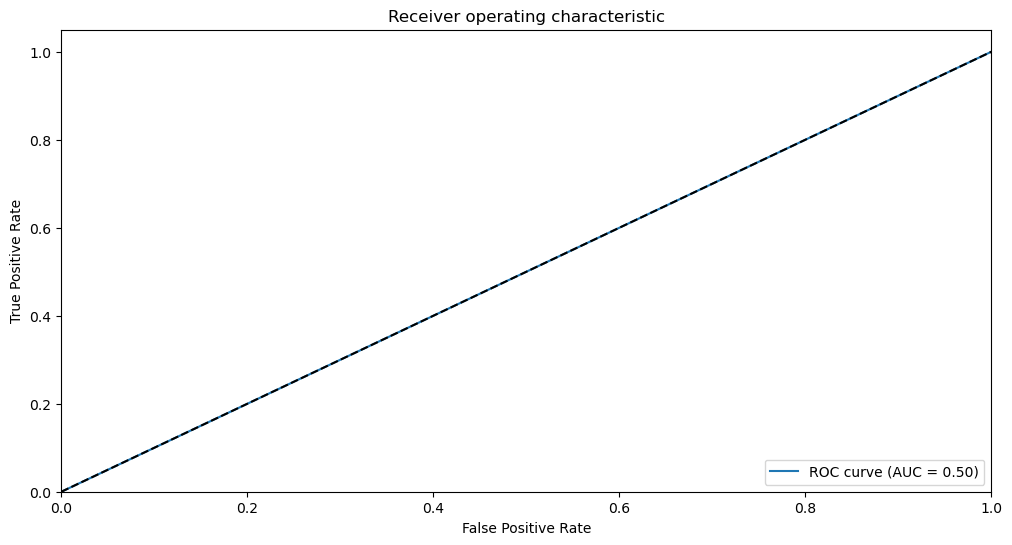

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(baseline_metrics["true_lbl"], 
                                         baseline_metrics["pred_score"])

# Plot ROC curve
plot_roc_curves([fpr], [tpr])

## Models

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

### K-Fold Cross-Validation Function

This function performs K-fold cross-validation from scratch for binary classification models.

### Nested Cross-Validation Function

Nested cross-validation is used to evaluate model performance while tuning hyperparameters in a robust way.

We used nested cross-validation here because our dataset is relatively small and the target classes are imbalanced. The inner loop allows us to tune the model’s hyperparameters using only the training data, while the outer loop evaluates the model on completely unseen data. This ensures that our performance metrics are unbiased and realistic, giving a true picture of how the model would perform in the real world, instead of overestimating performance from using the same data for tuning and testing.

<img src="../image/Nestedcv.png" width="500"/>



## Decision Trees

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
# Cross-validate a Decision Tree and compute performance metrics

results_dt = kfold_cv(X, y,model_class=DecisionTreeClassifier, model_params={"max_depth": 10, "random_state": 42})


Stratified Cross-Validation Results (Averages):
Accuracy : 0.72
Precision: 0.82
Recall   : 0.76
F1 Score : 0.79
Bank Cost: 73.50


In [25]:
# Run nested cross-validation on the dataset X, y.

best_params_list, outer_bank_cost, outer_accs, avg_acc = nested_cv(X, y, base_model=DecisionTreeClassifier())

Fold 1: Best Params: {'max_depth': 5, 'random_state': 42, 'threshold': 0.9}, Accuracy: 0.610, Precision: 0.823, Recall: 0.564, AUC: 0.701, Bank Cost: 146
Fold 2: Best Params: {'max_depth': 5, 'random_state': 42, 'threshold': 0.9}, Accuracy: 0.555, Precision: 0.881, Recall: 0.421, AUC: 0.676, Bank Cost: 121
Fold 3: Best Params: {'max_depth': 5, 'random_state': 42, 'threshold': 0.9}, Accuracy: 0.450, Precision: 0.812, Recall: 0.279, AUC: 0.679, Bank Cost: 146
Fold 4: Best Params: {'max_depth': 5, 'random_state': 42, 'threshold': 0.9}, Accuracy: 0.530, Precision: 0.926, Recall: 0.357, AUC: 0.692, Bank Cost: 110
Fold 5: Best Params: {'max_depth': 5, 'random_state': 42, 'threshold': 0.9}, Accuracy: 0.640, Precision: 0.870, Recall: 0.571, AUC: 0.711, Bank Cost: 120

Average Accuracy across outer folds: 0.557
Average Bank Cost across outer folds: 128.600


In [26]:
# Retrain Decision Tree on the full dataset using the best hyperparameters
# from nested CV and a best decision threshold of 0.8

best_params_final= {'max_depth': 5} 
results_dt_tuned= kfold_cv(X, y, DecisionTreeClassifier, best_params_final,threshold =0.9)


Stratified Cross-Validation Results (Averages):
Accuracy : 0.54
Precision: 0.90
Recall   : 0.39
F1 Score : 0.54
Bank Cost: 59.40


## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier 

In [28]:
# Cross-validate a Random Forest and compute performance metrics

results_rf = kfold_cv(X, y, model_class=RandomForestClassifier,model_params={"n_estimators": 100, "random_state": 42})


Stratified Cross-Validation Results (Averages):
Accuracy : 0.70
Precision: 0.86
Recall   : 0.68
F1 Score : 0.76
Bank Cost: 60.70


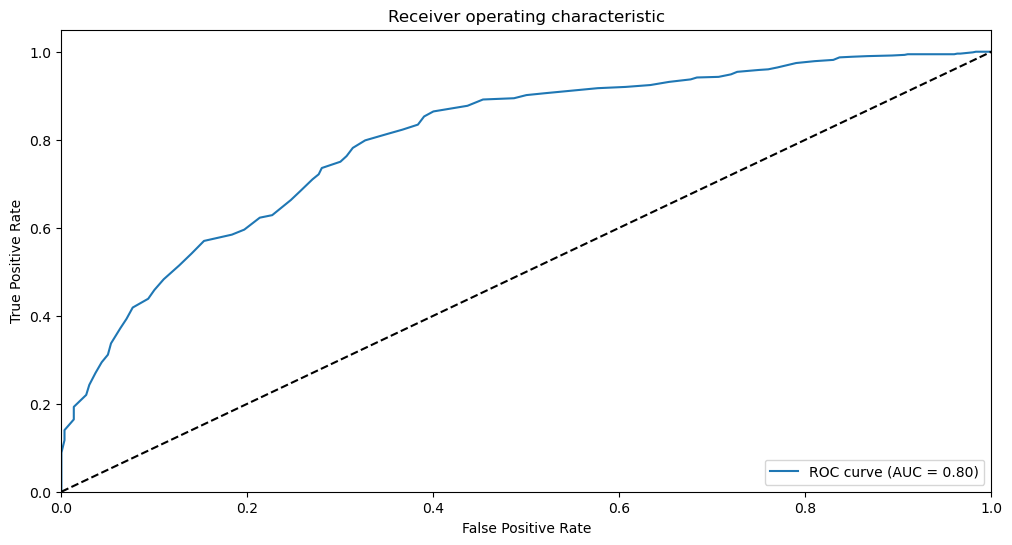

Baseline model AUC: 0.801


In [29]:
# Compute ROC before hyperparameter tuning
from sklearn.metrics import roc_curve, auc

# Extract true labels and predicted probabilities
y_true_all = results_rf['true_lbl']
y_proba_all = results_rf['pred_score']
fpr, tpr, thresholds = roc_curve(y_true_all, y_proba_all)
roc_auc = auc(fpr, tpr)

# Plot
plot_roc_curves([fpr], [tpr])
print(f"Baseline model AUC: {roc_auc:.3f}")

In [30]:
# Run nested cross-validation for Random Forest on the dataset X, y.

best_params_list, outer_bank_cost, outer_accs, avg_acc = nested_cv(X, y, base_model=RandomForestClassifier())

Fold 1: Best Params: {'max_depth': 10, 'random_state': 42, 'n_estimators': 100, 'threshold': 0.8}, Accuracy: 0.600, Precision: 0.895, Recall: 0.486, AUC: 0.823, Bank Cost: 112
Fold 2: Best Params: {'max_depth': None, 'random_state': 42, 'n_estimators': 100, 'threshold': 0.8}, Accuracy: 0.555, Precision: 0.892, Recall: 0.414, AUC: 0.768, Bank Cost: 117
Fold 3: Best Params: {'max_depth': None, 'random_state': 42, 'n_estimators': 100, 'threshold': 0.8}, Accuracy: 0.545, Precision: 0.866, Recall: 0.414, AUC: 0.779, Bank Cost: 127
Fold 4: Best Params: {'max_depth': None, 'random_state': 42, 'n_estimators': 300, 'threshold': 0.8}, Accuracy: 0.595, Precision: 0.928, Recall: 0.457, AUC: 0.832, Bank Cost: 101
Fold 5: Best Params: {'max_depth': None, 'random_state': 42, 'n_estimators': 100, 'threshold': 0.8}, Accuracy: 0.580, Precision: 0.900, Recall: 0.450, AUC: 0.800, Bank Cost: 112

Average Accuracy across outer folds: 0.575
Average Bank Cost across outer folds: 113.800


In [31]:
# Retrain Random Forest on the full dataset using the best hyperparameters
# from nested CV and a best decision threshold of 0.8

best_params_final= {'n_estimators': 300, 'max_depth': None} 
results_rf_tuned= kfold_cv(X, y, RandomForestClassifier, best_params_final,threshold =0.8) 



Stratified Cross-Validation Results (Averages):
Accuracy : 0.61
Precision: 0.92
Recall   : 0.48
F1 Score : 0.63
Bank Cost: 50.70


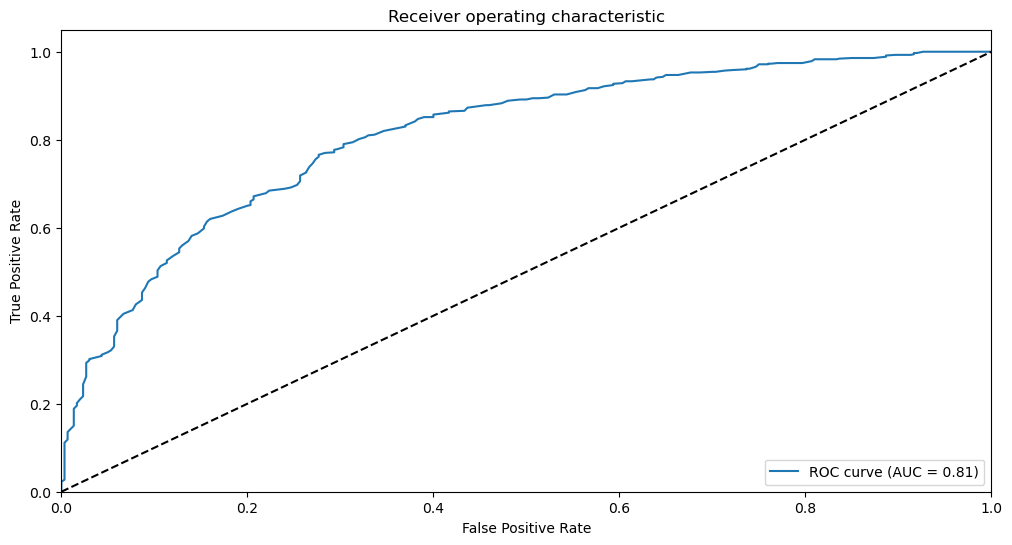

Tuned model AUC: 0.812


In [32]:
# Compute ROC after hyperparameter tuning
from sklearn.metrics import roc_curve, auc

# Extract true labels and predicted probabilities
y_true_all = results_rf_tuned['true_lbl']
y_proba_all = results_rf_tuned['pred_score']
fpr, tpr, thresholds = roc_curve(y_true_all, y_proba_all)
roc_auc = auc(fpr, tpr)

# Plot
plot_roc_curves([fpr], [tpr])
print(f"Tuned model AUC: {roc_auc:.3f}")

## Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [34]:
# Compute SVM model for default parameters using k fold cross validation. : for RBF kernel


svm_params = {
    "kernel": "rbf",          # rbf kernel
    "C": 1.0,                 # regularization strength
    "probability": True,      # enables predict_proba
    "random_state": 42
}

results_rbf = kfold_cv(X, y, model_class=SVC, model_params=svm_params, n_splits=10, random_state=42, threshold=0.8)



Stratified Cross-Validation Results (Averages):
Accuracy : 0.66
Precision: 0.89
Recall   : 0.58
F1 Score : 0.70
Bank Cost: 54.80


In [35]:
# Compute SVM model for default parameters using k fold cross validation. : for polynomial kernel

svm_params = {
    "kernel": "poly",          # polynomial kernel
    "C": 1.0,                 
    "probability": True,     
    "random_state": 42
}

results_poly = kfold_cv(X, y, model_class=SVC, model_params=svm_params, n_splits=10, random_state=42, threshold=0.8)


Stratified Cross-Validation Results (Averages):
Accuracy : 0.63
Precision: 0.90
Recall   : 0.53
F1 Score : 0.66
Bank Cost: 54.00


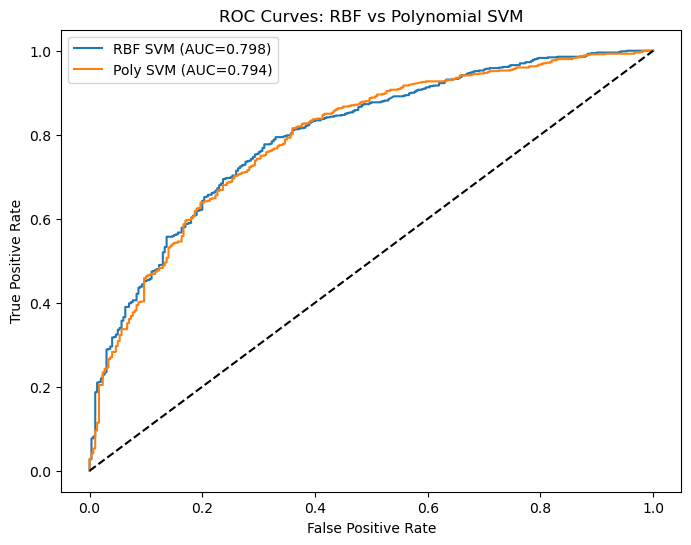

In [36]:
# ROC Curve before hyperparameter tuning

# --- Base RBF SVM ---

y_true_rbf = results_rbf['true_lbl']
y_proba_rbf = results_rbf['pred_score']

fpr_rbf, tpr_rbf, _ = roc_curve(y_true_rbf, y_proba_rbf)
auc_rbf = auc(fpr_rbf, tpr_rbf)

# --- Base Polynomial SVM ---

y_true_poly = results_poly['true_lbl']
y_proba_poly = results_poly['pred_score']

fpr_poly, tpr_poly, _ = roc_curve(y_true_poly, y_proba_poly)
auc_poly = auc(fpr_poly, tpr_poly)

# --- Plot both curves ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr_rbf, tpr_rbf, label=f"RBF SVM (AUC={auc_rbf:.3f})")
plt.plot(fpr_poly, tpr_poly, label=f"Poly SVM (AUC={auc_poly:.3f})")
plt.plot([0,1],[0,1],'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: RBF vs Polynomial SVM")
plt.legend()
plt.show()


In [37]:
from sklearn.model_selection import StratifiedKFold

## Nested Cross-Validation Function For SVM

Nested cross-validation is used to evaluate model performance while tuning hyperparameters in a robust way.

In [39]:
best_params_list, outer_accuracies, avg_outer_acc = nested_cv_svm(X, y)

Fold 1: Best Params: {'C': 100, 'gamma': 0.001, 'threshold': 0.8}, Accuracy: 0.655, Precision: 0.908, Recall: 0.564, AUC: 0.775, Cost: 101
Fold 2: Best Params: {'C': 1, 'gamma': 0.1, 'threshold': 0.8}, Accuracy: 0.650, Precision: 0.898, Recall: 0.564, AUC: 0.816, Cost: 106
Fold 3: Best Params: {'C': 0.1, 'gamma': 0.01, 'threshold': 0.8}, Accuracy: 0.640, Precision: 0.847, Recall: 0.593, AUC: 0.740, Cost: 132
Fold 4: Best Params: {'C': 0.1, 'gamma': 0.01, 'threshold': 0.8}, Accuracy: 0.645, Precision: 0.926, Recall: 0.536, AUC: 0.824, Cost: 95
Fold 5: Best Params: {'C': 100, 'gamma': 0.1, 'threshold': 0.8}, Accuracy: 0.615, Precision: 0.832, Recall: 0.564, AUC: 0.761, Cost: 141


In [40]:
## Retrain the SVM model with your best hyperparameters and threshold

best_C = 0.1          
best_gamma = 0.01     
best_threshold = 0.8  

# Define the SVM parameters
svm_params = {
    "kernel": "rbf",          # RBF kernel
    "C": best_C,              # regularization strength
    "gamma": best_gamma,      # RBF kernel parameter
    "probability": True,      # enable probability estimates for thresholding
    "random_state": 42
}

results_rbfkernel_tuned = kfold_cv(X, y,model_class=SVC,model_params=svm_params,n_splits=10,random_state=42,threshold=best_threshold)



Stratified Cross-Validation Results (Averages):
Accuracy : 0.63
Precision: 0.89
Recall   : 0.55
F1 Score : 0.68
Bank Cost: 57.00


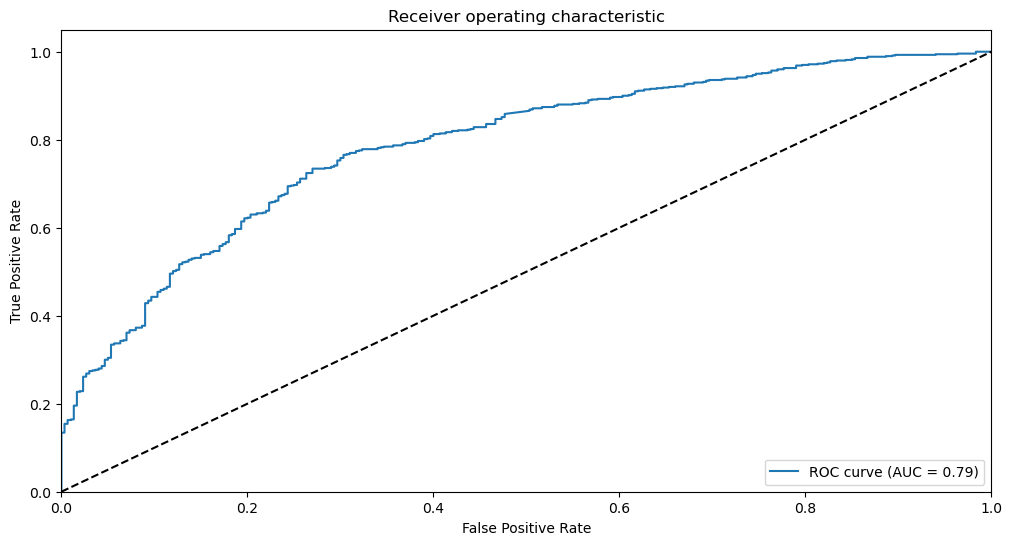

SVM model AUC: 0.787


In [41]:
## Compute ROC for tuned hyperparameters

y_true_all = results_rbfkernel_tuned['true_lbl']
y_proba_all = results_rbfkernel_tuned['pred_score']
fpr, tpr, thresholds = roc_curve(y_true_all, y_proba_all)
roc_auc = auc(fpr, tpr)

# Plot (assuming your plot_roc_curves accepts lists of fpr/tpr)
plot_roc_curves([fpr], [tpr])
print(f"SVM model AUC: {roc_auc:.3f}")


## Model Comparison

In [42]:
# Collect only the bank costs
cost_results = {
    "Baseline": baseline_metrics["bank_cost"], 
    "Decision Tree (Tuned)": results_dt_tuned["bank_cost"],
    "SVM (Tuned)": results_rbfkernel_tuned["bank_cost"],
    "Random Forest (Tuned)": results_rf_tuned["bank_cost"]
    
}

# Create DataFrame
cost_df = pd.DataFrame.from_dict(cost_results, orient="index", columns=["Bank Cost"])

print(cost_df)


                       Bank Cost
Baseline                   150.0
Decision Tree (Tuned)       59.4
SVM (Tuned)                 57.0
Random Forest (Tuned)       50.7


In [43]:
baseline = baseline_metrics["bank_cost"]
best_model = cost_df["Bank Cost"].min()
improvement = (baseline - best_model) / baseline * 100
print(f"Best model reduced cost by {improvement:.2f}% compared to baseline")


Best model reduced cost by 66.20% compared to baseline


In [44]:
from sklearn.metrics import roc_auc_score

auc_results = {
    "Baseline": roc_auc_score(baseline_metrics["true_lbl"], baseline_metrics["pred_score"]),
    "Decision Tree (Tuned)": roc_auc_score(results_dt_tuned["true_lbl"], results_dt_tuned["pred_score"]),
    "RBF Kernel (Tuned)": roc_auc_score(results_rbfkernel_tuned["true_lbl"], results_rbfkernel_tuned["pred_score"]),
    "Random Forest (Tuned)": roc_auc_score(results_rf_tuned["true_lbl"], results_rf_tuned["pred_score"])
    
}

auc_df = pd.DataFrame.from_dict(auc_results, orient="index", columns=["AUC"])
print(auc_df)


                            AUC
Baseline               0.500000
Decision Tree (Tuned)  0.731143
RBF Kernel (Tuned)     0.787133
Random Forest (Tuned)  0.812076


# Conclusion:


* Given the bank’s emphasis on minimizing the cost of misclassifying non-creditworthy customers, the Tuned **Random Forest** is the **optimal model**.
* It achieves the lowest Bank Cost (50.7) and the highest AUC (0.81), indicating both financial efficiency and strong predictive performance.
* Decision Tree and SVM perform reasonably well but are outperformed in both cost and discrimination.